# Forecasting Property Prices with Linear and Regularized Models

## Table of Contents

- [1. Introduction](#1.-Introduction)
- [2. Exploring and Preparing the Dataset](#2.-Exploring-and-Preparing-the-Dataset)
- [3. Building the OLS Linear Model](#3.-Building-the-OLS-Linear-Model)
- [4. Applying Ridge and Lasso Regressions](#4.-Applying-Ridge-and-Lasso-Regressions)
- [5. Conclusion](#5.-Conclusion)

## 1. Introduction

In this project, we will delve into the analysis of a real estate dataset to predict property prices (in USD) using various regression models. Our dataset includes key features such as the property size (in square feet), year of construction, and the presence of a sea view, most of which are critical in determining property values.

We will start by exploring the dataset to understand its structure and the relationships between different features. Following this, we'll prepare the data for modeling, ensuring it's clean and suitable for analysis. 

We will build an Ordinary Least Squares (OLS) linear regression model to establish a baseline for price predictions. Next, we will enhance our approach by applying Ridge and Lasso regressions, which are techniques designed to address potential overfitting and improve model performance.

By comparing these models, we aim to identify the most effective method for predicting real estate prices based on the available features. To begin, let's import the necessary libraries and take a quick look at our dataset.

In [1]:
# Import libraries for data manipulation, visualization, and machine learning
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Load the real estate dataset and display the first few rows
real_estate = pd.read_csv('Datasets/real_estate_data.csv')
real_estate.head()

,price,size,year,view
0,234314.144,643.09,2015,No sea view
1,228581.528,656.22,2009,No sea view
2,281626.336,487.29,2018,Sea view
3,401255.608,1504.75,2015,No sea view
4,458674.256,1275.46,2009,Sea view


The first five rows show that property prices vary significantly with features such as size, year of construction, and sea view. Typically, larger properties and those with a sea view tend to have higher prices. However, the year of construction shows a mixed impact, with both newer and older properties exhibiting a wide range of prices.

## 2. Exploring and Preparing the Dataset

After loading the real estate dataset, we will explore it further by checking for duplicate rows, missing data, and outliers, and by displaying data types and summary statistics.

In [2]:
# Check for the number of duplicate rows in the dataset
real_estate.duplicated().sum()

0

As we can see, the dataset has no duplicate rows.

In [3]:
# Display information about the dataset, including data types and non-null counts
real_estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   100 non-null    float64
 1   size    100 non-null    float64
 2   year    100 non-null    int64  
 3   view    100 non-null    object 
dtypes: float64(2), int64(1), object(1)
memory usage: 3.3+ KB


The dataset contains `100` entries with no missing values. The columns `price` and `size` are stored as floats, `year` as an integer, and `view` as a categorical object. The data types are appropriate for analysis, with numerical columns ready for regression and the `view` column suitable for categorical handling.

In [4]:
# Generate descriptive statistics for all columns, including categorical data
real_estate.describe(include='all')

,price,size,year,view
count,100.000000,100.000000,100.000000,100
unique,NaN,NaN,NaN,2
top,NaN,NaN,NaN,No sea view
freq,NaN,NaN,NaN,51
mean,292289.470160,853.024200,2012.600000,NaN
std,77051.727525,297.941951,4.729021,NaN
min,154282.128000,479.750000,2006.000000,NaN
25%,234280.148000,643.330000,2009.000000,NaN
50%,280590.716000,696.405000,2015.000000,NaN
75%,335723.696000,1029.322500,2018.000000,NaN


Property prices range from approximately `154k` to `500k` USD, with a mean of about `$292k`. Property sizes vary from `480` to `1,843` square feet, with an average of `853` square feet. Moreover, properties are distributed across years with a mean year of `2012`. The most common view type is `No sea view`, which appears in `51` entries.

To check for outliers in the dataset, we'll create a boxplot for each numerical feature.

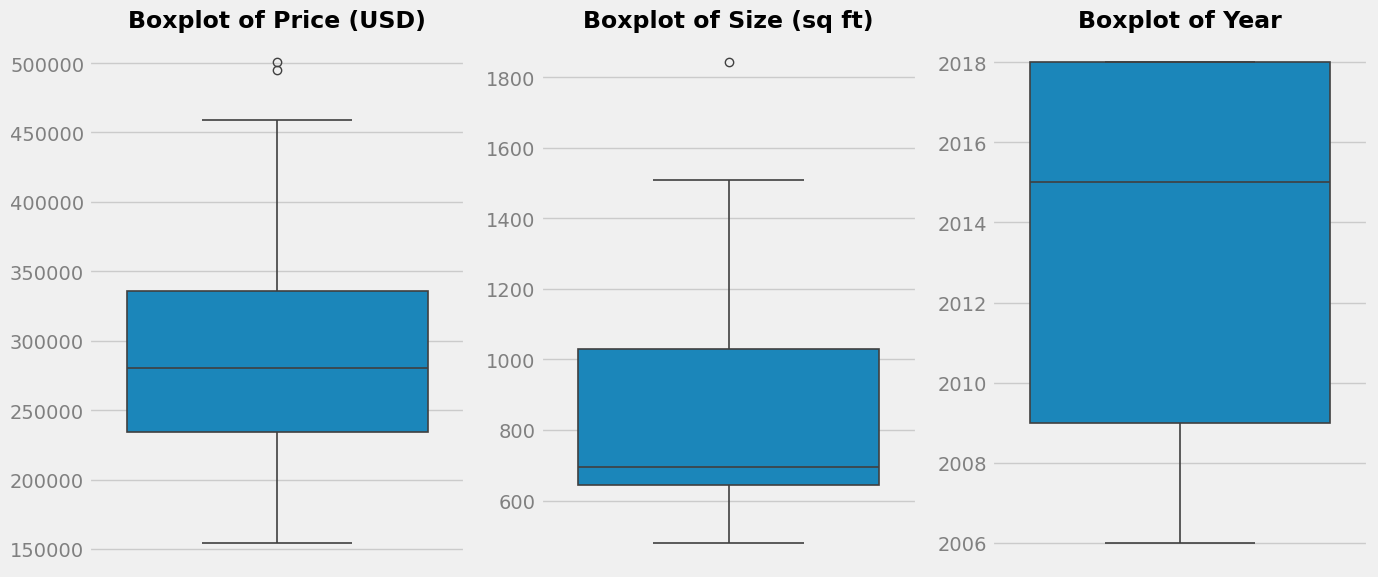

In [5]:
# Apply the 'fivethirtyeight' style
plt.style.use('fivethirtyeight')

# Create a figure with a single row and three columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

# Boxplot for 'price' on the first subplot
sns.boxplot(data=real_estate, y='price', linewidth=1.2, ax=axes[0])
axes[0].set_title('Boxplot of Price (USD)', weight='bold', size=17, pad=8)
axes[0].tick_params(axis='y', colors='grey')
axes[0].set_ylabel('')

# Boxplot for 'size' on the second subplot
sns.boxplot(data=real_estate, y='size', linewidth=1.2, ax=axes[1])
axes[1].set_title('Boxplot of Size (sq ft)', weight='bold', size=17, pad=8)
axes[1].tick_params(axis='y', colors='grey')
axes[1].set_ylabel('')

# Boxplot for 'year' on the third subplot
sns.boxplot(data=real_estate, y='year', linewidth=1.2, ax=axes[2])
axes[2].set_title('Boxplot of Year', weight='bold', size=17, pad=8)
axes[2].tick_params(axis='y', colors='grey')
axes[2].set_ylabel('')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

The property years range from `2006` to `2018`, which appears reasonable. However, we observe some high outliers in both the price and size of properties. Next, we'll calculate the correlation between both features and create a scatter plot of `size` versus `price`.

Correlation between size and price: 0.8630


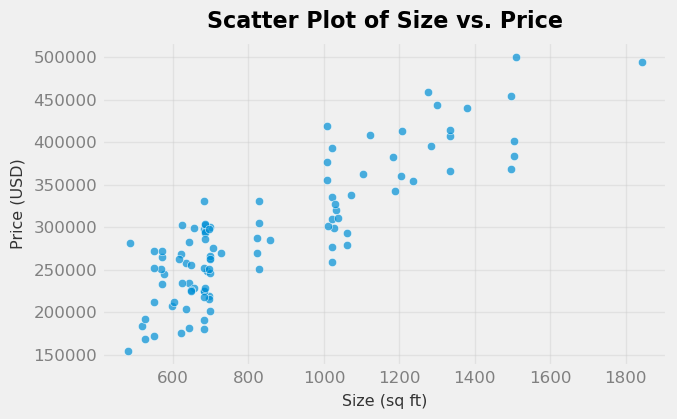

In [6]:
# Calculate and print the correlation between 'size' and 'price'
size_price_corr = real_estate['size'].corr(real_estate['price'])
print(f"Correlation between size and price: {size_price_corr:.4f}")

# Set figure size and create a scatter plot with 'size' on x-axis and 'price' on y-axis
plt.figure(figsize=(6.5, 4))
sns.scatterplot(data=real_estate, x='size', y='price', alpha=0.7)

# Set title and axis labels with customized styling
plt.title('Scatter Plot of Size vs. Price', weight='bold', size=16, pad=10)
plt.ylabel('Price (USD)', c='#333333', labelpad=6, size=11.5)
plt.xlabel('Size (sq ft)', c='#333333', labelpad=6, size=11.5)

# Customize tick parameters and grid lines
plt.xticks(size=12, color='grey')
plt.yticks(size=12, color='grey')
plt.grid(alpha=0.4)

# Display the plot
plt.show()

There is a strong linear correlation of `0.863` between the `size` and `price` columns, indicating that larger property sizes are associated with higher prices. Therefore, the outliers in both `size` and `price` are consistent with this relationship, and we will retain them for training our regression models.

After exploring our dataset, we'll first convert the `view` column to numerical values by mapping `Sea view` to `1` and `No sea view` to `0`. Moreover, we’ll rename the column to `sea_view` for better clarity.

In [7]:
# Convert 'view' column to numerical values and rename it to 'sea_view'
real_estate['sea_view'] = real_estate['view'].map({'Sea view': 1, 'No sea view': 0})

# Drop the original 'view' column
real_estate.drop(['view'], axis=1, inplace=True)

# Display the first few rows of the updated DataFrame
real_estate.head()

,price,size,year,sea_view
0,234314.144,643.09,2015,0
1,228581.528,656.22,2009,0
2,281626.336,487.29,2018,1
3,401255.608,1504.75,2015,0
4,458674.256,1275.46,2009,1


## 3. Building the OLS Linear Model

Now that we've fully prepared our dataset, it's time to build the OLS linear regression model. First, it’s crucial to test the individual impact of each feature on the target variable by calculating F-scores and p-values, and to determine whether these relationships are statistically significant.

In univariate linear regression, the normality of error terms is crucial for hypothesis testing and calculating p-values. While the F-test assumes normally distributed residuals for validity in small samples, slight deviations from normality typically don't significantly impact results in large datasets.

With our sample of `100` observations, the central limit theorem helps ensure that the distribution of error terms approximates normality, even if the underlying error terms are not normally distributed. This makes the assumption of normality less critical.

In [8]:
# Select feature columns and target variable
X = real_estate.drop(['price'], axis=1)
y = real_estate['price']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit StandardScaler on the training data, then transform training and test data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize LinearRegression and fit the OLS model to the training data
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)


# Perform univariate linear regression test for each feature
f_scores, p_values = f_regression(X_train, y_train)

# Create a DataFrame with feature names, F-scores, and p-values
f_regression_df = pd.DataFrame({
    'Feature': ['size', 'year', 'sea_view'],
    'F-Score': f_scores.round(2),
    'P-Value': p_values.round(4)
})

# Display the DataFrame
f_regression_df

,Feature,F-Score,P-Value
0,size,236.96,0.0000
1,year,0.81,0.3707
2,sea_view,11.45,0.0011


The analysis shows that `size` and `sea_view` are highly significant predictors of property prices with F-scores of `236.96` and `11.45`, and p-values of `0.0000` and `0.0011`. In contrast, `year` is not a significant predictor, with an F-score of `0.81` and a p-value of `0.3707`. 

The p-value of `year` is higher than the typical significance threshold of `0.05`, showing that the relationship between year and property prices is likely due to random chance rather than a strong, consistent effect.

Following the same steps as before, we'll select our feature columns (excluding `year`) and the target variable, split the data into training and testing sets, and fit the OLS model to the training data. Afterward, we will evaluate the model's performance using the R-squared metric.

In [9]:
# Select feature columns except 'year' and target variable
X = real_estate[['size', 'sea_view']]
y = real_estate['price']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit StandardScaler on the training data, then transform training and test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize LinearRegression and fit the OLS model to the training data
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)

# Calculate R-squared scores for training and test sets
train_score = ols_model.score(X_train, y_train)
test_score = ols_model.score(X_test, y_test)

# Print R-squared scores, intercept, and coefficients
print(f'Training R-squared: {train_score:.4f}, Test R-squared: {test_score:.4f}')
print(f'Intercept: {ols_model.intercept_.round(2)}')
print(f'Coefficients: {ols_model.coef_.round(2)}')

Training R-squared: 0.8771, Test R-squared: 0.9167
Intercept: 295315.54
Coefficients: [66971.93 27330.6 ]


The OLS model demonstrates strong predictive performance with R-squared values of `0.8771` for training and `0.9167` for testing, indicating very good generalization. The intercept reflects a base price of `$295,315.54`. Moreover, each standard deviation increase in property size raises the price by about `66,971.93 USD`, while having a sea view adds a positive amount to the price. To accurately interpret the coefficient for `sea_view`, we need to reverse the scaling transformation to determine the actual price increase associated with having a sea view.

Next, let's calculate the adjusted R-squared. This metric accounts for the number of predictors in the model, providing a more accurate measure of model fit when comparing models with different numbers of features:

$$R^2_{adj.} = 1 - (1-R^2)×\frac{n-1}{n-p-1}$$

In [10]:
# Define a function to calculate adjusted R-squared for a given model and test set
def adjusted_r2(model, X_test, y_test):
    
    # Predict the target values using the test set
    y_pred = model.predict(X_test)

    # Calculate R-squared with the number of observations and features in the test set
    r2 = r2_score(y_test, y_pred)
    n = X_test.shape[0]
    p = X_test.shape[1]

    # Calculate Adjusted R-squared and return the result
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return f'Adjusted R-squared: {adj_r2:.4f}'

# Calculate and return adjusted R-squared for the OLS model
adjusted_r2(ols_model, X_test, y_test)

'Adjusted R-squared: 0.9069'

The adjusted R-squared of `0.9069` is slightly lower than the test R-squared of `0.9167`, indicating that while the model explains a high proportion of the variance in the test set, the adjusted metric accounts for the number of features and provides a more conservative estimate of the model's performance.

Next, let's use K-fold cross-validation to ensure the OLS model's performance is reliable and not just tailored to our specific train-test split. This will provide a more robust estimate of the model's generalization ability.

In [11]:
# Perform 5-fold cross-validation on the training data and get the R-squared values
cv_scores = cross_val_score(ols_model, X_train, y_train, cv=5, scoring='r2')

# Print individual R-squared scores for each fold and the mean R-squared score
print(f'Cross-validated R-squared scores for each fold: {cv_scores.round(2)}')
print(f'Mean Cross-validated R-squared: {cv_scores.mean():.4f}')

Cross-validated R-squared scores for each fold: [0.95 0.75 0.78 0.8  0.85]
Mean Cross-validated R-squared: 0.8240


The cross-validated R-squared scores range from `0.75` to `0.95`, with a mean of `0.8240`, indicating somewhat inconsistent model performance across different folds. This is not entirely comparable to the training R-squared of `0.8771` and the test R-squared of `0.9167`, but it suggests that the model generalizes well across training, test, and cross-validation sets.

## 4. Applying Ridge and Lasso Regressions

Ridge regression helps manage correlated features by applying L2 regularization, which can stabilize the estimates. On the other hand, Lasso regression performs L1 regularization, potentially reducing some feature coefficients to zero and aiding in feature selection. 

Once again, we'll use only the `size` and `sea_view` features for our predictions. In addition, we will optimize Ridge and Lasso regression models, testing various parameters to find the best combination for performance.

It's worth noting that [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) uses cross-validation to evaluate model performance across different parameter combinations. Since it averages the results over multiple data splits, the estimates are generally reliable, reducing the risk of overfitting and providing a more robust estimate of the model's performance.

In [12]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'alpha': [0.1, 1, 10, 100, 1000],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],
    'max_iter': [100, 500, 1000]
}

# Initialize Ridge and GridSearchCV, and fit GridSearchCV to the training data
ridge = Ridge()
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Extract the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Calculate R-squared scores for training and test sets
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)

# Print the best parameters and the performance metrics of the optimized model
print(f'Best Parameters: {best_params}')
print(f'Training R-squared: {train_score:.4f}')
print(f'Test R-squared: {test_score:.4f}')

Best Parameters: {'alpha': 1, 'max_iter': 100, 'solver': 'svd'}
Training R-squared: 0.8770
Test R-squared: 0.9155


The Ridge regression model, optimized with `alpha=1`, `max_iter=100`, and `solver='svd'`, shows strong predictive performance. The training R-squared of `0.8770` indicates that the model fits the training data very well, while the test R-squared of `0.9155` suggests that the model generalizes effectively to unseen data, confirming robustness.

The test performance could be better due to random variations in the data or because the test set may contain patterns that the model fits more effectively than the training set. This difference could also suggest that the model avoids overfitting.

In [13]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'alpha': [0.1, 1, 10, 100, 1000],
    'max_iter': [100, 500, 1000],
    'tol': [0.0001, 0.001, 0.01]
}

# Initialize Lasso and GridSearchCV, and fit GridSearchCV to the training data
lasso = Lasso()
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Extract the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Calculate R-squared scores for training and test sets
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)

# Print features used by Lasso (non-zero coefficients)
used_features = np.array(X.columns)[best_model.coef_ != 0]
print(f'Features used by Lasso: {used_features}')

# Print the best parameters and the performance metrics of the optimized model
print(f'Best Parameters: {best_params}')
print(f'Training R-squared: {train_score:.4f}')
print(f'Test R-squared: {test_score:.4f}')

Features used by Lasso: ['size' 'sea_view']
Best Parameters: {'alpha': 1000, 'max_iter': 100, 'tol': 0.001}
Training R-squared: 0.8768
Test R-squared: 0.9134


The optimized Lasso model confirmed the importance of the two selected features, `size` and `sea_view`, in predicting property prices. Using `alpha=1000`, `max_iter=100`, and `tol=0.001`, the model delivered strong performance with a training R-squared of `0.8768` and a test R-squared of `0.9134`. This indicates the model effectively captures the relationship between these key features and property prices while generalizing well to new data.

The test performance could be better due to random variations in the data or because the test set may contain patterns that the model fits more effectively than the training set. This difference could also suggest that the model avoids overfitting.

## 5. Conclusion

In this project, we used a real estate dataset to predict property prices (in USD) using three regression models. The dataset includes key features such as property size (in square feet), year of construction, and the presence of a sea view, most of which are critical in determining property values. After loading the data, we checked for duplicate rows, missing data, outliers, and reviewed the data types and summary statistics. The dataset contained `100` entries, with no duplicates or missing values, and the data types were suitable for analysis.

To identify outliers, we created a boxplot for each numerical feature. Property years ranged from `2006` to `2018`, which appeared reasonable. Since there is a strong linear correlation of `0.863` between `size` and `price`, indicating that larger properties tend to have higher prices, we retained the outliers in both features for training our regression models. 

To prepare the data for modeling, we renamed and converted the `view` column to numerical values and scaled the features to ensure similar value ranges. Before building the OLS linear regression model, we used a histogram to check the residual distribution, determining whether we could confidently use the F-test and calculate p-values. Although the residuals weren't perfectly normally distributed, our sample size of `100` observations was sufficient, as minor deviations from normality are generally acceptable in practice.

Based on our analysis, we found that the relationship between year and property prices is likely due to random chance rather than a significant, consistent effect. Therefore, we excluded the `year` column from our models:

- The OLS model demonstrates strong predictive performance, with R-squared values of `0.8771` for training, `0.9167` for testing, and an adjusted R-squared of `0.9069` on the test data, indicating very good generalization. The intercept suggests a base price of `295,315.54 USD`. Additionally, each standard deviation increase in property size raises the price by approximately `66,971.93 USD`, while having a sea view adds a positive amount to the price.
- The cross-validated R-squared scores range from `0.75` to `0.95`, with a mean of `0.8240`, demonstrating somewhat inconsistent model performance across different folds. Nevertheless, the model generalizes well across the training, test, and cross-validation sets.
- We optimized Ridge and Lasso regression models, testing various parameters to find the best performance using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). The latter employs cross-validation, averaging the results over multiple data splits, which typically provides reliable estimates and reduces the risk of overfitting.
- The optimized Ridge regression model `(alpha=1, max_iter=100, solver='svd')` demonstrates strong predictive performance, with a training R-squared of `0.8770` and a test R-squared of `0.9155`, indicating effective generalization. Furthermore, the Lasso model `(alpha=1000, max_iter=100, tol=0.001)` confirmed the significance of `size` and `sea_view` in predicting property prices. It achieved a training R-squared of `0.8768` and a test R-squared of `0.9134`, showing robust performance as well.
- The slightly better test performance in both models could result from random variations in the data or better fit to patterns in the test set, suggesting that overfitting is not an issue.

The OLS, Ridge, and Lasso models all demonstrate strong and comparable performance, with cross-validation affirming their reliability. Additionally, each model predicts effectively without noticeable overfitting.